# 测试集
测试集用以测试和评估学习器对新样本的判断能力，具体来说就是用测试集上的测试误差来对泛化误差进行估计。其中，测试集可以通过**留出法**（hold-out，将数据集分成互斥的两个集合，一个用于训练(66.7%-75%)，另一个用于测试），**交叉验证法**（cross validation，将数据集分成k个大小相似的子集，用其中的k-1个作为训练集，其他作为测试集。类似于Jackknife法），**自助法**。

# 自助法 (bootstrapping)
自助法通过随机可放回地从原始样本中取样，来估计参数的分布(robust estimates of standard errors and confidence intervals of a population parameter like a mean, median, proportion, odds ratio, correlation coefficient or regression coefficient).

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# make a random samples
samp = np.random.randn(10000)

In [3]:
# bootstrap method
def bootstrap0(a, size):
    "algorithm without using numpy"
    samp_bs = []
    for _ in range(size):
        i = int(random.random() * size)
        samp_bs.append(a[i])
    return samp_bs

def bootstrap(a, size):
    "algorithm using numpy"
    return np.random.choice(a, size, replace=True)

In [4]:
# generate bootstrap sample
samp_bs0 = bootstrap0(samp, 10000)
samp_bs  = bootstrap(samp, 10000)

/home/szqtc/Softwares/Anaconda/INSTALLED/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


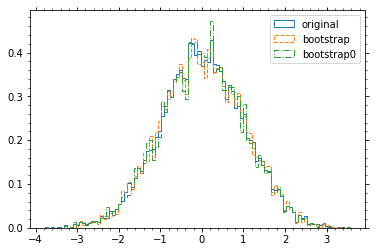

In [5]:
# compare two samples

h, bins, pa = plt.hist(samp, bins=100, histtype='step', normed=True, label='original')
plt.hist(samp_bs, bins=bins, histtype='step', normed=True, label='bootstrap', ls='--')
plt.hist(samp_bs0, bins=bins, histtype='step', normed=True, label='bootstrap0', ls='-.')
plt.legend()

In [6]:
print('重采样样本由{:.2%} (~1-1/e)的原始样本构成。'.format(len(set(samp_bs))/len(set(samp))))

重采样样本由63.57% (~1-1/e)的原始样本构成。


## 参数估计

In [7]:
# 做500次自助
n_sample = 5
samples = [bootstrap(samp, 10000) for _ in range(n_sample)]

In [8]:
# 估计样本均值的误差
means = [samp_.mean() for samp_ in samples]
print('evaluated mean={:.4f} +/- {:.4f}'.format(samp.mean(), np.std(means)))
print('expected mean=0.00 +/- {:.2f}'.format(np.sqrt(1./10000))) # std(X_mean) = X_std/sqrt(N)

evaluated mean=0.0013 +/- 0.0097
expected mean=0.00 +/- 0.01


In [9]:
# 估计方差的误差
vars_ = [samp_.var() for samp_ in samples]
print('evaluated var={:.4f} +/- {:.4f}'.format(samp.var(), np.std(vars_)))
print('expected var=1.0000 +/- {:.4f}'.format( np.sqrt(2.*1.**4/10000))) # std(X_var) = sqrt(2/N)*sigma_X^2

evaluated var=0.9997 +/- 0.0094
expected var=1.0000 +/- 0.0141


# 刀切法 (Jackknife)
刀切法每次按顺序去掉样本集中的一些样本，重新做参数估计。由不同的样本估计出的参数值可以用来获得参数的方差和偏差。

Jackknifing, which is similar to bootstrapping, is used in statistical inference to estimate the bias and standard error (variance) of a statistic, when a random sample of observations is used to calculate it.

In [22]:
# 做50次刀切
n_sample = 200
num_per_samp = samp.size//n_sample

samples_jk = []
for i in range(n_sample):
    if i == 0:
        s = []
    else:
        s = samp[(i-1)*num_per_samp::num_per_samp].tolist()
    s += samp[(i+1)*num_per_samp::num_per_samp].tolist()
    samples_jk.append(np.array(s))

### 参数估计
- **delete-1 Jackknife Samples** are selected by taking the original data vector and deleting one observation from the set.  
    The ith Jackknife Replicate is defined as the value of the estimator $s(\cdot)$ evaluated at the i-th Jackknife sample. ${\hat \theta}_{(i)} := s(X_{[i]})$.   
    The Jackknife Standard Error is defined 
    $$SE({\hat \theta}) = \sqrt{ \frac{n-1}{n} \sum_{i=1}^{n} ({\hat \theta}_{(i)} - {\hat \theta}_{(\cdot)})^2}$$,
    where ${\hat \theta}_{(\cdot)} = 1/n \times \sum_{i=1}^n {\hat \theta}_{(i)}$.
    
- **delete − d Jackknife**, where $\sqrt{n} < d < n-1$, is a consistent estimator.
    The Jackknife Standard Error is defined 
    $$SE({\hat \theta}) = \sqrt{ \frac{n-d}{d \, C_n^d} \sum_{i=1}^{n} ({\hat \theta}_{(i)} - {\hat \theta}_{(\cdot)})^2}$$

In [28]:
from scipy.special import comb

def eval_err(samp, delete_num, func):
    thetas = np.array([func(s) for s in samp])
    thetas_err = ((thetas-thetas.mean())**2).sum()
    print(thetas_err)
    
    N = len(samp)
    d = delete_num
    c_n_d = comb(N-d, d)
    print(N, d, c_n_d)
    return np.sqrt(thetas_err/c_n_d*((N-d)/d))

In [29]:
# 估计样本均值的误差
means_jk = [samp_.mean() for samp_ in samples_jk]
print('evaluated mean={:.4f} +/- {:.4f}'.format(samp.mean(), eval_err(samples_jk, num_per_samp, np.mean))) #????
print('expected mean=0.00 +/- {:.2f}'.format(np.sqrt(1./10000))) # std(X_mean) = X_std/sqrt(N)

5.076466066789313
200 50 2.0128660909731936e+40
evaluated mean=0.0013 +/- 0.0000
expected mean=0.00 +/- 0.01
